### Goal
#### Predict the spread of the virus for the next 14 days
##### Selected Country : Brazil
___

##### Dependencies
_____

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from fbprophet import Prophet
from statsmodels.tools.eval_measures import rmse
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# default plot size
plt.rcParams['figure.figsize'] = 10,12

%matplotlib inline

##### Load Data
____

In [3]:
country = 'Brazil'

###### Confirmed

In [4]:
confirmed = pd.read_csv('../resources/time_series_covid19_confirmed_global.csv', parse_dates=True)
cond = confirmed['Country/Region'] == country

confirmed=confirmed[cond]

confirmed.drop(columns = ['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1, inplace=True)
confirmed = confirmed.transpose()
confirmed.reset_index(inplace=True)

confirmed.columns = ['ds', 'confirmed']
confirmed['ds'] = pd.to_datetime(confirmed['ds'])

###### Deaths

In [5]:
deaths = pd.read_csv('../resources/time_series_covid19_deaths_global.csv', parse_dates=True)
cond = deaths['Country/Region'] == country

deaths=deaths[cond]

deaths.drop(columns = ['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1, inplace=True)
deaths = deaths.transpose()
deaths.reset_index(inplace=True)

deaths.columns = ['ds', 'deaths']
deaths['ds'] = pd.to_datetime(deaths['ds'])

###### Recovered

In [6]:
recovered = pd.read_csv('../resources/time_series_covid19_recovered_global.csv', parse_dates=True)
cond = recovered['Country/Region'] == country

recovered=recovered[cond]

recovered.drop(columns = ['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1, inplace=True)
recovered = recovered.transpose()
recovered.reset_index(inplace=True)

recovered.columns = ['ds', 'recovered']
recovered['ds'] = pd.to_datetime(recovered['ds'])

###### Final

In [7]:
master = pd.merge(pd.merge(confirmed, deaths, how='inner'), recovered, how='inner')
master.tail(5)

,ds,confirmed,deaths,recovered
78,2020-04-09,18092,950,173
79,2020-04-10,19638,1057,173
80,2020-04-11,20727,1124,173
81,2020-04-12,22192,1223,173
82,2020-04-13,23430,1328,173


##### Data Analysis
____

In [8]:
cond1 = master['ds'] == master['ds'].max()

total_cases  = master[cond1]['confirmed'].values[0]
total_deaths = master[cond1]['deaths'].values[0]
total_recovered = master[cond1]['recovered'].values[0]

cond2 = master['confirmed'] > 0
first_case = master[cond2]['ds'].min()

cond3 = master['deaths'] > 0
first_death = master[cond3]['ds'].min()

cond4 = master['recovered'] > 0
first_recover = master[cond4]['ds'].min()


summary_data = [{
    'Snapshot'        : master['ds'].max(),
    'First Case'      : first_case,
    'First Death'     : first_death,
    'First Recover'   : first_recover,
    'Total Cases'     : total_cases,
    'Total Deaths'    : total_deaths,
    'Total Recovered' : total_recovered
}]

summary = pd.DataFrame(data=summary_data, columns=list(summary_data[0].keys()))

summary

,Snapshot,First Case,First Death,First Recover,Total Cases,Total Deaths,Total Recovered
0,2020-04-13,2020-02-26,2020-03-17,2020-03-16,23430,1328,173


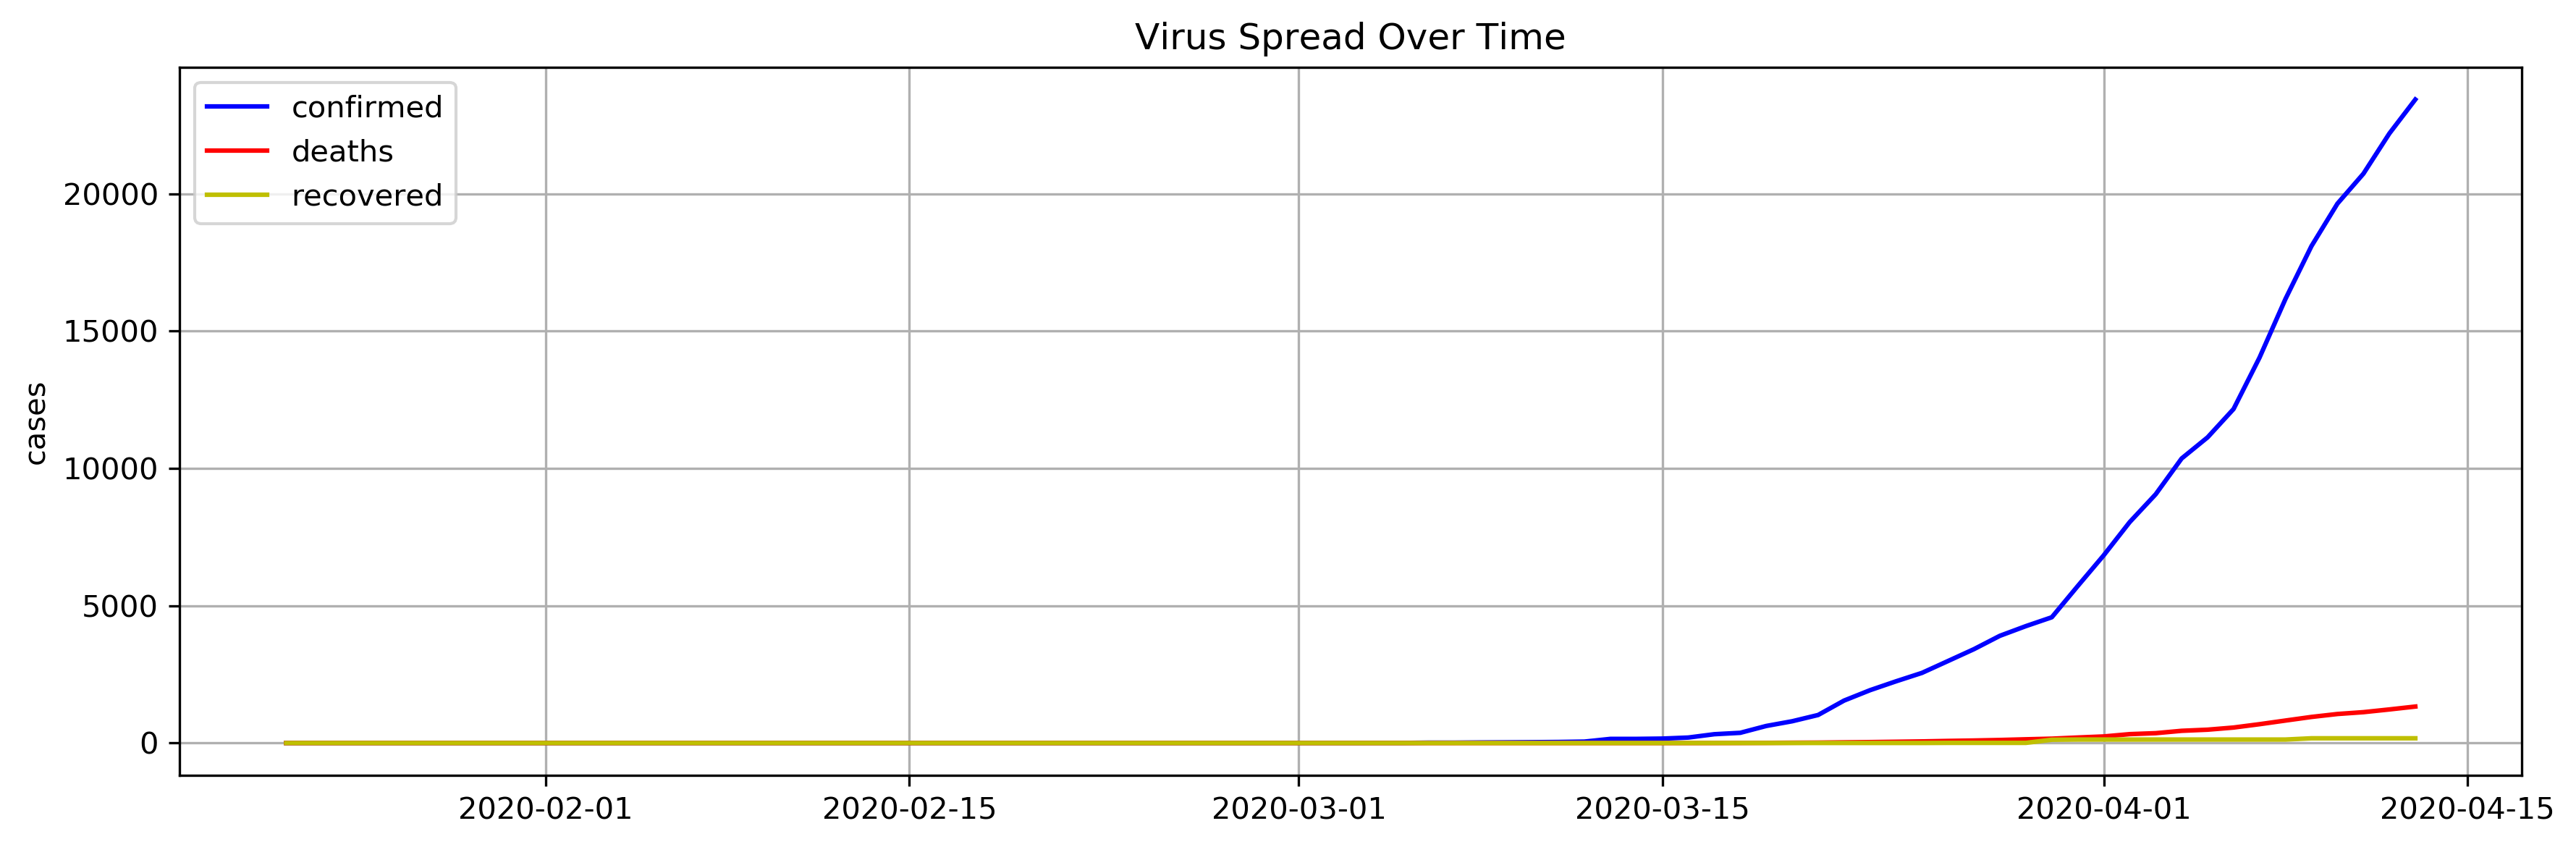

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,4), dpi=300)

axes.plot('ds', 'confirmed', color='b', data=master, label='confirmed')
axes.plot('ds', 'deaths', color='r', data=master, label='deaths')
axes.plot('ds', 'recovered', color='y', data=master, label='recovered')
axes.set_title('Virus Spread Over Time')
axes.set_ylabel('cases')
axes.grid(True)
axes.legend()

plt.tight_layout()

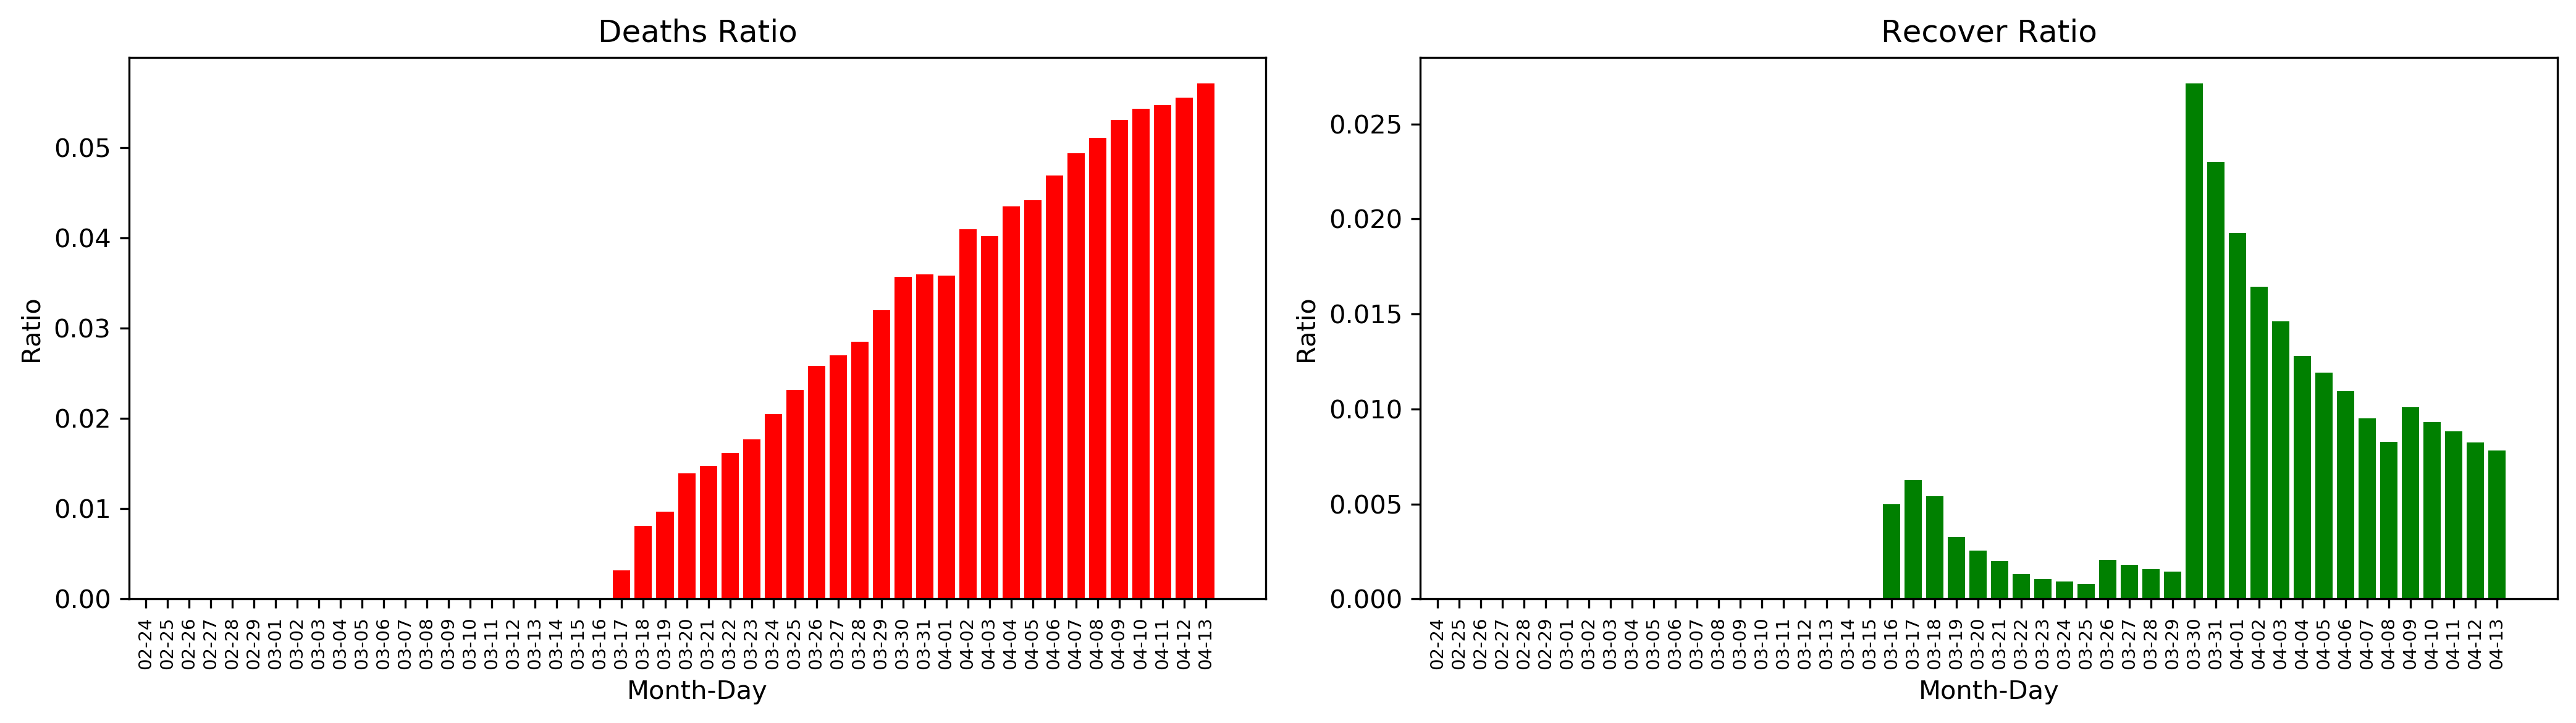

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4), dpi=300)

labels = master['ds'].dt.strftime('%m-%d')

axes[0].bar(labels, master['deaths'] / (master['confirmed'] - master['recovered']), data=master, color='r')
axes[0].set_title('Deaths Ratio')
axes[0].set_xticklabels(labels=labels, rotation=90, fontsize=7)
axes[0].set_xlabel('Month-Day')
axes[0].set_ylabel('Ratio')
axes[0].grid(False)

axes[1].bar(labels, master['recovered'] / (master['confirmed'] - master['deaths']), data=master, color='g')
axes[1].set_title('Recover Ratio')
axes[1].set_xticklabels(labels=labels, rotation=90, fontsize=7)
axes[1].set_ylabel('Ratio')
axes[1].set_xlabel('Month-Day')
axes[1].grid(False)


plt.tight_layout()

##### Split Confirmed, Deaths, Recover DataFrames
____

In [11]:
confirmed = master[['ds', 'confirmed']].copy(deep=True)
confirmed.columns = ['ds', 'y']

deaths = master[['ds', 'deaths']].copy(deep=True)
deaths.columns = ['ds', 'y']

recovered = master[['ds', 'recovered']].copy(deep=True)
recovered.columns = ['ds', 'y']

##### Create and Fit the Model
____

In [12]:
c_model = Prophet(interval_width=0.95).fit(confirmed)
d_model = Prophet(interval_width=0.95).fit(deaths)
r_model = Prophet(interval_width=0.95).fit(recovered)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


##### Perform Predictions
____

In [13]:
c_predictions = c_model.make_future_dataframe(periods=14, include_history=True)
c_forecast = c_model.predict(c_predictions)

d_predictions = d_model.make_future_dataframe(periods=14, include_history=True)
d_forecast = d_model.predict(d_predictions)

r_predictions = r_model.make_future_dataframe(periods=14, include_history=True)
r_forecast = r_model.predict(r_predictions)

##### Plot Results
____

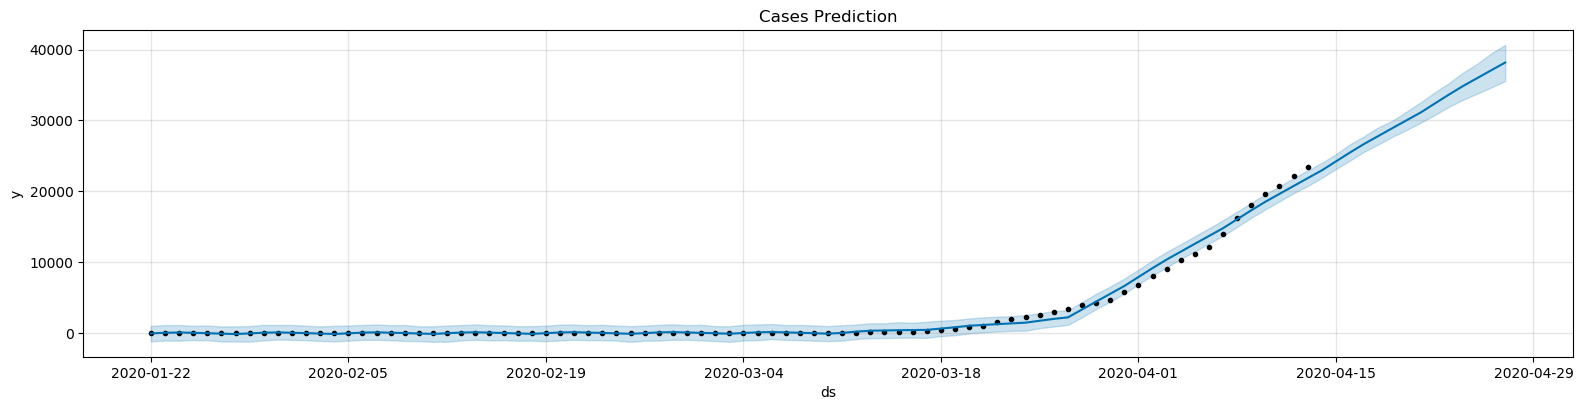

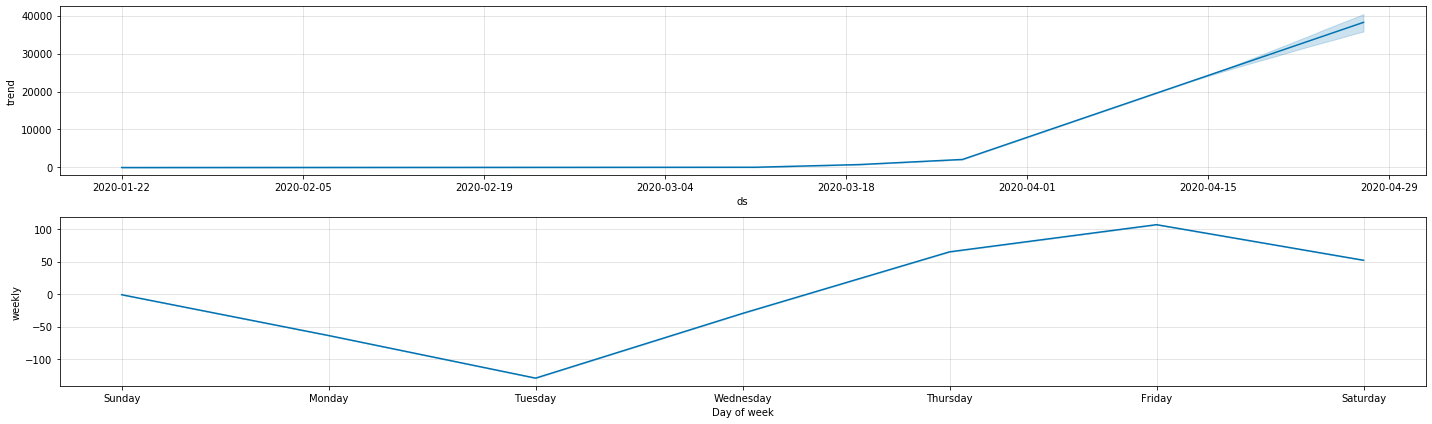

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,4), dpi=100)

c_model.plot(c_forecast, figsize=(16,4), ax=axes)
c_model.plot_components(c_forecast,figsize=(20,6))
axes.set_title('Cases Prediction')

plt.tight_layout()

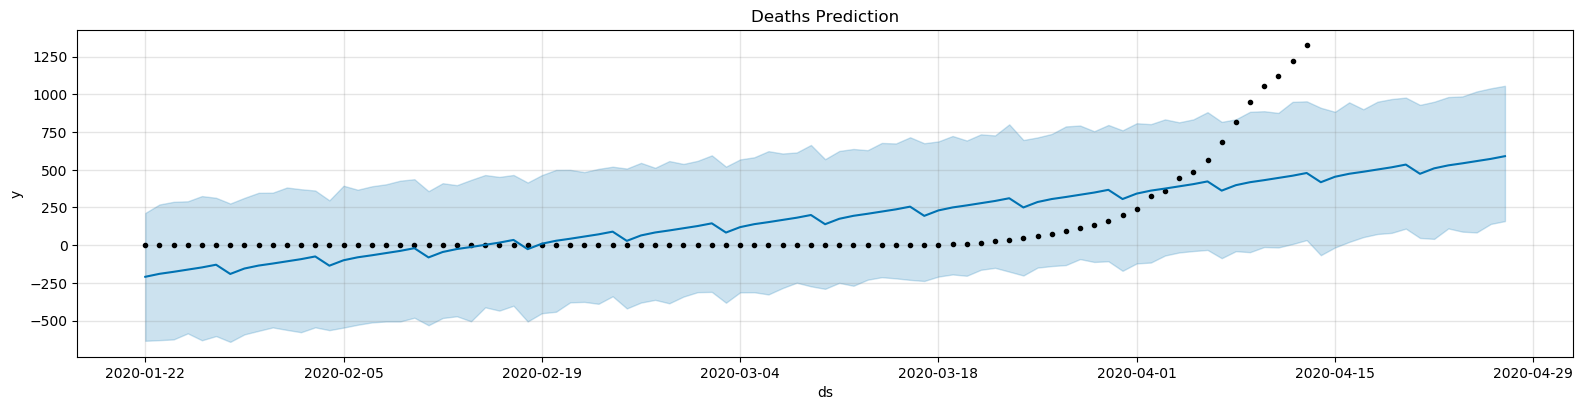

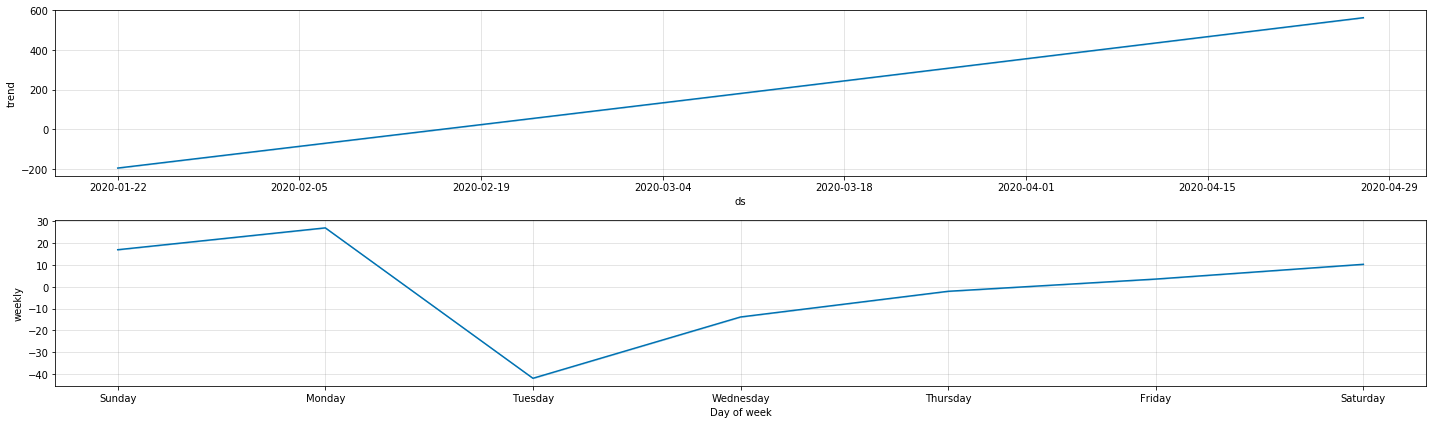

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,4), dpi=100)

d_model.plot(d_forecast, figsize=(16,4), ax=axes)
d_model.plot_components(d_forecast,figsize=(20,6))
axes.set_title('Deaths Prediction')

plt.tight_layout()

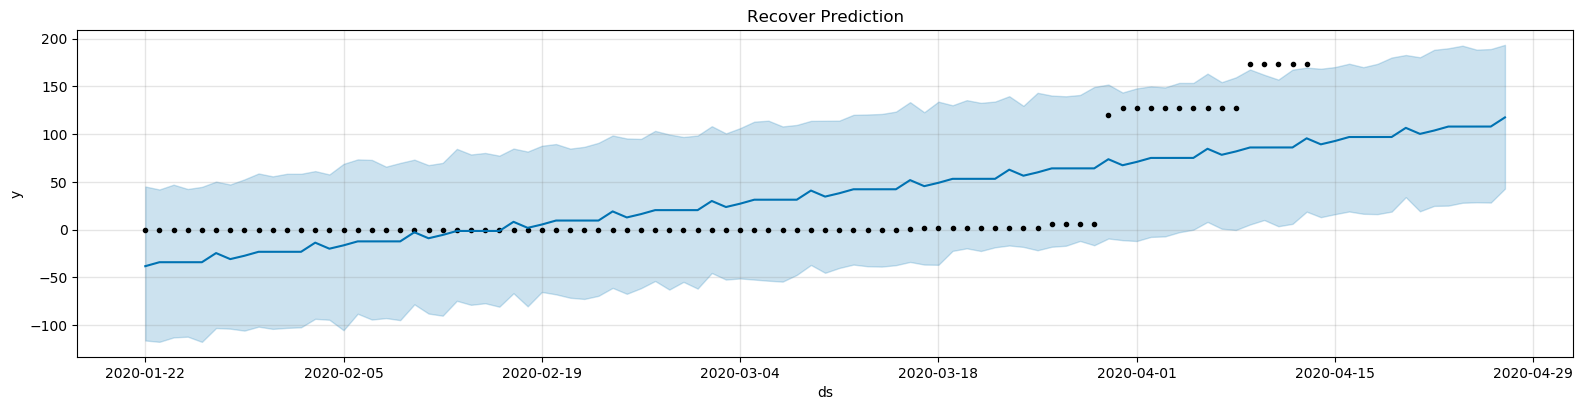

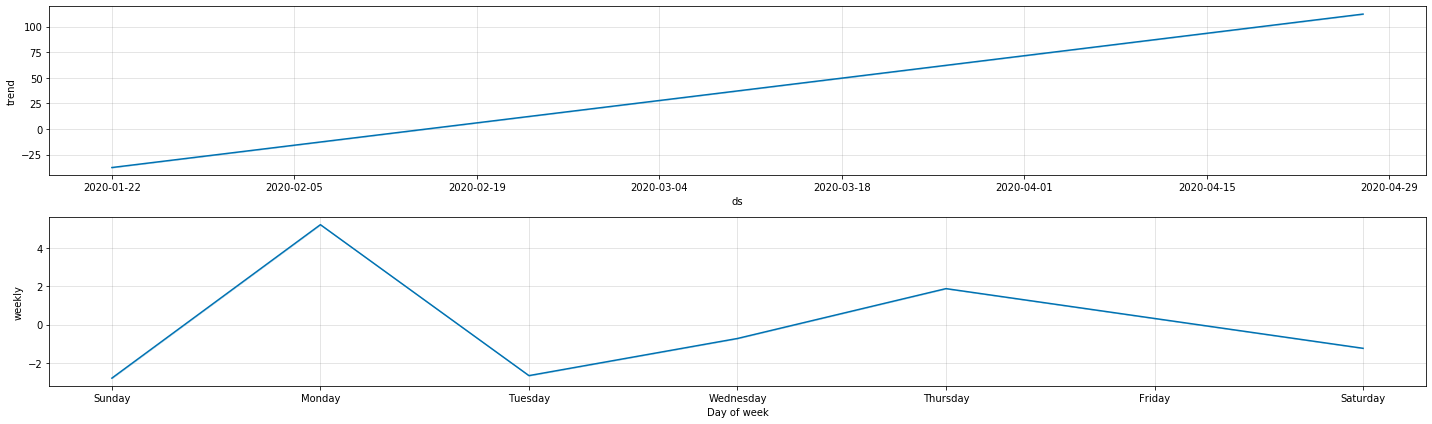

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,4), dpi=100)

r_model.plot(r_forecast, figsize=(16,4), ax=axes)
r_model.plot_components(r_forecast,figsize=(20,6))
axes.set_title('Recover Prediction')

plt.tight_layout()

In [24]:
r_forecast[['ds', 'yhat']].tail(14)

,ds,yhat
83,2020-04-14,89.230843
84,2020-04-15,92.734712
85,2020-04-16,96.903032
86,2020-04-17,96.909989
87,2020-04-18,96.916882
88,2020-04-19,96.923850
89,2020-04-20,106.501474
90,2020-04-21,100.185091
91,2020-04-22,103.688960
92,2020-04-23,107.857280
